# Import data, identify contours and convert to points

ITEM classes: [-9999.0, -1248.0, -1018.0, -715.0, -411.0, -122.0, 184.0, 527.0, 829.0, 1161.0]


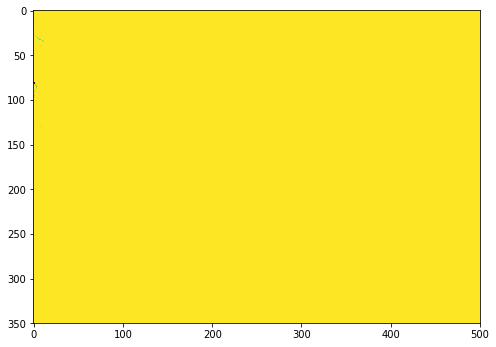

In [51]:
import numpy as np
import datacube
import rasterio
import rasterio.features
import glob
from osgeo import gdal
from shapely.geometry import Point
from shapely.geometry import shape
import scipy.ndimage
from scipy.interpolate import griddata
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
from matplotlib import pyplot as plt

"""
TODO: Investigate scipy.interpolate.RectBivariateSpline, scipy.interpolate.interp2d,
spipy.interpolate.RegularGridInterpolator
"""


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
    
    # Close file
    dataset = None  


# Select polygon
polygon_ID = 180

# # Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
# plotting_subset = np.index_exp[:, :]
plotting_subset = np.index_exp[2550:2900, 1500:2000]
# plotting_subset = np.index_exp[2350:2450, 2130:2230]
    
# Import raster
filename = glob.glob("/g/data2/v10/ITEM/offset_products/ITEM_OFFSET_{}*.tif".format(polygon_ID))[0]
src_ds = gdal.Open(filename)
srcband = src_ds.GetRasterBand(1)
srcarray = srcband.ReadAsArray() 
yrows, xcols = srcarray.shape
prj = src_ds.GetProjection()
geotrans = src_ds.GetGeoTransform()
(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size) = geotrans

# Copy original layer so array can be modified 
item_array = np.copy(srcarray)

# Set nodata to NaN, and force 0 values to a low negative  (-9999) to allow correct 
# contour extraction (i.e. make "0" data sit beneath the lowest ITEM tidal stage)
item_array[item_array == -6666] = np.nan
item_array[item_array == 0] = -9999 
item_classes = sorted(np.unique(item_array[~np.isnan(item_array)]))
print("ITEM classes: {}".format(item_classes))

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(item_array[plotting_subset])  
plt.show()

# Erode background of area with data to fix artificial contours at plot edge
background = np.isfinite(item_array)
background_mask = scipy.ndimage.binary_erosion(background)

# Compute local minima and subtract from source array to identify contours
neighborhood = morphology.generate_binary_structure(len(item_array.shape), 2)
local_mins = filters.minimum_filter(item_array, footprint = neighborhood)
contours = (item_array - local_mins) != 0
contours[~background_mask] = 0

# # Return only input ITEM offset data for non-background and local minima areas
# item_array[~contours] = np.nan
# plt.figure(figsize = (8, 8))
# plt.imshow(item_array[plotting_subset])

# # # Export to file
# # write_geotiff(fname = "output_data/contours_{}.tif".format(polygon_ID), 
# #               data = item_array, 
# #               geo_transform = geotrans, 
# #               projection = prj, 
# #               nodata_val = 0)

# # Convert cells to array of points; use geotransform to convert indices to coordinates
# y_inds, x_inds = np.nonzero(contours)
# centroids = [(y_ind * y_size + upleft_y + (y_size / 2),
#               x_ind * x_size + upleft_x + (x_size / 2)) for (y_ind, x_ind) in zip(y_inds, x_inds)]

# points = np.array(centroids)
# values = item_array[contours]


In [52]:
from skimage import measure
import matplotlib.cm as cm

# Optimise by subsetting to area with valid data
y_inds, x_inds = np.nonzero(scipy.ndimage.binary_dilation(item_array < item_classes[9]))
xmin_inds = np.amin(x_inds)
xmax_inds = np.amax(x_inds)
ymin_inds = np.amin(y_inds)
ymax_inds = np.amax(y_inds)
plotting_subset = np.index_exp[ymin_inds:ymax_inds, xmin_inds:xmax_inds]

# # Display the image and plot all contours found
# fig, ax = plt.subplots(figsize = (20, 20))
# ax.imshow(item_array[plotting_subset], interpolation='nearest', cmap=plt.cm.gray)
# cols = cm.rainbow(np.linspace(0, 1, 11))

contour_dict = list()

contour_list = [-9999] + item_classes[1:9] + [item_classes[9] - 1.0]
contour_list2 = [-9999] + item_classes[1:9] + [item_classes[9]] + [item_classes[9]]
for n, item_class in enumerate(contour_list):
    
    print(item_class)    
    contours = measure.find_contours(item_array[plotting_subset], item_class)
    contours_concat = np.concatenate((contours))
    contours_val = np.full((contours_concat.shape[0], 1), fill_value = contour_list2[n+1])        
    contour_dict.append(np.hstack((contours_concat, contours_val)))    
       
#     for contour in contours:
#         ax.plot(contour[:, 1], contour[:, 0], linewidth = 0.3, color = cols[n])
    
# ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig("test.png", dpi = 600)
# plt.show()

alldata = np.concatenate(contour_dict)
alldata = alldata[~np.isnan(alldata).any(axis=1)]
alldata 

centroids = tuple(map(tuple, alldata[:,0:2]))
centroids

# Convert cells to array of points; use geotransform to convert indices to coordinates
y_inds, x_inds = alldata[:,0] + ymin_inds, alldata[:,1] + xmin_inds
centroids = [(y_ind * y_size + upleft_y + (y_size / 2),
              x_ind * x_size + upleft_x + (x_size / 2)) for (y_ind, x_ind) in zip(y_inds, x_inds)]
# print(centroids)

points = np.array(centroids)
values = alldata[:,2]


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


-9999
-1248.0
-1018.0
-715.0
-411.0
-122.0
184.0
527.0
829.0
1160.0


# Interpolate points
Exports a DEM by interpolating previously extracted contours. This uses the `linear` method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using [Qhull](www.qhull.org) before performing linear barycentric interpolation on each triangle.

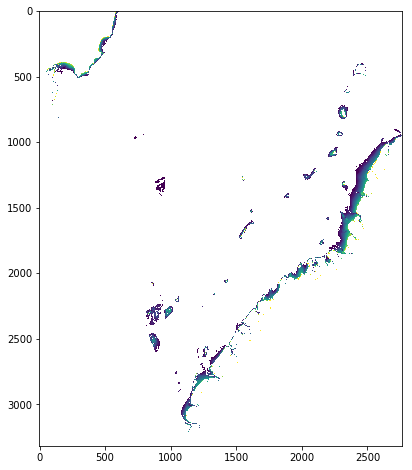

In [53]:
# Extract bounds of ITEM layer
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid (from, to, by in metres)
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
interpolated_array = griddata(points, values, (grid_y, grid_x), method = "linear")

# Mask out NaNs, zero values and max tidal stage from original ITEM offset layer
gooddata_mask = ((srcarray != -6666) & (srcarray != 0) & (srcarray != item_classes[9]))
interpolated_array[~gooddata_mask] = np.nan

# Plot
plt.figure(figsize = (8, 8))
plt.imshow(interpolated_array[plotting_subset])
plt.show()

# Export to tif
write_geotiff(fname = "output_data/dem_{}_test.tif".format(polygon_ID), 
              data = interpolated_array, 
              geo_transform = geotrans, 
              projection = prj, 
              nodata_val = np.nan)
